The below code aims to compare various machine learning models from accuracy and fairness perspective. We have considered K-nearest Neighbours, Logistic Regression, Neural Nwetwork and Random Forest.

The code is structured in the following way:
 1. Data processing - In this secvtion the basisc sytatistics and domiensions of the data are obtained. Further the data is cleaned and trabsformed in a way it is usable.
 
 2. A module to train the data using specific hyperparameters: This module is designed to run the scikit package modules for each of the machine learning  models. It also loops thorugh various shyperamater settings to find the set of hyperparameter that have best accuracy vs fairness metrics tradeoff. 
 
 3. A module to calculate the accuracy and fairness metrics of the models : This module is designed to calculate the four fairness mterics such as demograohic parity, Predictive parity, equalised odds and mutual information. This module is used in the mdoel training modules to find out the nest settings.
 
 4. A module to store in microsoft excel and display the results : This module helps to store the accuracy and fairness results for all loops and exposrt into excel for furtjer analysis.
 
 5. Statistical tests - These modules are used to perform the hypotheses testing using Wilcoxon signed-rank test and Levene's test
 
 

### Contents

1. [Packages Used](#packages)<br><br>
2. [Classification programs used](#Classification)<br><br>
3. [Dataset1 - Bondora Peer to peer lending dataset](#Bondora)<br><br>
4. [Dataset2 - Gym fitness recommendation dataset](#Fitness)<br><br>
5. [Dataset3 - Auto insurance customers dataset](#insurance)<br><br>
6. [Runs and Results](#Results)<br><br>
7. [Statistical Tests](#Stats)<br><br>

### 1. Packages used<a id='packages'></a>

In [8]:
#Importing necessary packages in Python 
import sys
import pandas as pd
import numpy as np 
import warnings
import random
warnings.filterwarnings("ignore")

import openpyxl
from openpyxl import load_workbook
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy import stats

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model


from imblearn.over_sampling import SMOTE
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import Workbook, load_workbook




### 2. Classification programs used<a id='Classification'></a>

In [5]:


class Fair_Classification:
    
    def __init__(self,dataset,sensitive_features,name):

        """ The class instance is initialised with the dataset. The datset is marked as the 
        predictor variables as X and the predicted variables as Y. the dataset is also split into test and train sets.
        """
        self.X_features = dataset.drop('classification', axis=1)
        self.y_features = dataset['classification']
        self.sensitive_attribute=dataset[sensitive_features]
        self.X_train, self.X_test, self.y_train, self.y_test,self.s_train, self.s_test = train_test_split(self.X_features,self.y_features,self.sensitive_attribute,test_size=0.2, random_state=1)
        self.X=self.X_features
        self.y=self.y_features
        
        self.sensitive_features=sensitive_features # This the is the sensitive or the protecetd variable
        self.s_train=self.X_train[self.sensitive_features]
        self.s_test=self.X_test[self.sensitive_features]
        self.protected_attribute=sensitive_features
        self.output=pd.DataFrame(columns=[])
        self.name=name

    
 
    # Fairness metrics were calculated, including demographic parity, predictive parity, equalized odds, and mutual information.
    def calculate_fairness(self, instance, turn):
        ''' The four fairness metrics, namely demographic parity, predictive parity, equalized odds, and mutual information, were computed in this module. The decision boundary was selected based on mutual information. '''

        # Fairness metrics and score initialization
        self.equalized_true_positive_rate = 10
        self.equalized_fpr = 10
        self.demographic_parity_calculated = 10
        self.score = 0

        # Decision boundary settings
        decision_boundary = (0.3, 0.7)
        decision_boundary_steps = 1
        thresholds = np.linspace(decision_boundary[0], decision_boundary[1], decision_boundary_steps)

        for decision_boundary in thresholds:
            ''' The model was executed with different decision thresholds within the range defined in the decision_boundary variable. '''

            # Predictions using k-fold cross-validation and calculating confusion matrix
            y_predicted_features = cross_val_predict(self.model, self.X, self.y, cv=5, method='predict_proba')[:, 1] >= decision_boundary
            self.y_predicted_features = y_predicted_features.astype(int)
            self.cm = confusion_matrix(self.y, self.y_predicted_features)
            self.score_0 = accuracy_score(self.y, self.y_predicted_features)

            # Identifying indices for sensitive and non-sensitive groups
            sensitive_groups_indices = (self.X[self.protected_attribute] == 1)
            nonsensitive_group_indices = (self.X[self.protected_attribute] == 0)

            # Grouping predictions by sensitive and non-sensitive groups
            sensitive_groups_predictions = self.y_predicted_features[sensitive_groups_indices]
            nonsensitive_group_predictions = self.y_predicted_features[nonsensitive_group_indices]

            # Calculating means for sensitive and non-sensitive groups
            sensitive_groups_mean = sensitive_groups_predictions.mean()
            nonsensitive_group_mean = nonsensitive_group_predictions.mean()

            # Calculating demographic parity
            self.demographic_parity_calculated_0 = abs(sensitive_groups_mean - nonsensitive_group_mean)

            # Calculating confusion matrices and related values
            cm_sensitive = confusion_matrix(self.y[sensitive_groups_indices], self.y_predicted_features[sensitive_groups_indices])
            tn_sensitive, fp_sensitive, fn_sensitive, tp_sensitive = cm_sensitive.ravel()

            cm_non_sensitive = confusion_matrix(self.y[nonsensitive_group_indices], self.y_predicted_features[nonsensitive_group_indices])
            tn_non_sensitive, fp_non_sensitive, fn_non_sensitive, tp_non_sensitive = cm_non_sensitive.ravel()

            tpr_sensitive = tp_sensitive / (tp_sensitive + fn_sensitive)
            tpr_non_sensitive = tp_non_sensitive / (tp_non_sensitive + fn_non_sensitive)

            fpr_sensitive = fp_sensitive / (fp_sensitive + tn_sensitive)
            fpr_non_sensitive = fp_non_sensitive / (fp_non_sensitive + tn_non_sensitive)

            # Calculating equalized true positive rate and equalized false positive rate
            self.equalized_true_positive_rate_0 = abs(tpr_sensitive - tpr_non_sensitive)
            self.equalized_fpr_0 = abs(fpr_sensitive - fpr_non_sensitive)
            self.mutinfo_0 = mutual_info_score(self.y_predicted_features, self.X[self.protected_attribute])

            # Recording fairness metrics if they improved compared to the previous run
            if self.demographic_parity_calculated_0 > 0:
                if self.equalized_true_positive_rate_0 > 0:
                    if self.equalized_fpr_0 > 0:
                        if self.score_0 / (self.demographic_parity_calculated_0 + self.equalized_true_positive_rate_0 + self.equalized_fpr_0) > self.score / (self.demographic_parity_calculated + self.equalized_true_positive_rate + self.equalized_fpr):
                            self.score = self.score_0
                            self.demographic_parity_calculated = self.demographic_parity_calculated_0
                            self.equalized_true_positive_rate = self.equalized_true_positive_rate_0
                            self.equalized_fpr = self.equalized_fpr_0
                            self.mutinfo = self.mutinfo_0
                            self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary) + str(turn), "Accuracy"] = self.score
                            self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary) + str(turn), "Demographic Parity %"] = self.demographic_parity_calculated * 100
                            self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary) + str(turn), "Equalized Odds TPR/Predictive Parity %"] = self.equalized_true_positive_rate * 100
                            self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary) + str(turn), "Equalized Odds FPR %"] = self.equalized_fpr * 100
                            self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary) + str(turn), "Mutual information"] = self.mutinfo

                            
    def calculate_fairness_mi(self, instance,turn):
        '''This module is similar to the calculate_fairness module . In this module, the decision boundary is selected on the basis of mutual information'''
        self.equalized_true_positive_rate=10
        self.equalized_fpr=10
        self.demographic_parity_calculated=10
        self.score=0
        self.mutinfo=10
        
        decision_boundary=(0.3, 0.7)
        decision_boundary_steps=10
        thresholds = np.linspace(decision_boundary[0], decision_boundary[1], decision_boundary_steps)
        
        for decision_boundary in thresholds:
            '''The model is run for different decision thresold in range defined in the decision_boundary variable'''
        
            y_predicted_features = cross_val_predict(self.model, self.X, self.y, cv=5, method='predict_proba')[:, 1] >= decision_boundary
            print("decision_boundary",decision_boundary)
            self.y_predicted_features = y_predicted_features.astype(int)
            self.cm = confusion_matrix(self.y, self.y_predicted_features)
            self.score_0 = accuracy_score(self.y, self.y_predicted_features)
            print("sel_score_pre",self.score_0)

            sensitive_groups_indices = (self.X[self.protected_attribute] == 1)#indices for which protected values is equal to 1
            nonsensitive_group_indices = (self.X[self.protected_attribute] == 0)#indices for which protected values is equal to 0

            sensitive_groups_predictions = self.y_predicted_features[sensitive_groups_indices]#indices of the predicted values for which protected values is equal to 1
            nonsensitive_group_predictions = self.y_predicted_features[nonsensitive_group_indices]

            sensitive_groups_mean = sensitive_groups_predictions.mean()
            nonsensitive_group_mean = nonsensitive_group_predictions.mean()

            self.demographic_parity_calculated_0 = abs(sensitive_groups_mean - nonsensitive_group_mean)#Demographic parity is calculated as the difference in the mean of the predicted value for th protecetd group and the other groups
            print("demo_pre",self.demographic_parity_calculated_0)
            print("demo_pre",self.demographic_parity_calculated_0)
            cm_sensitive = confusion_matrix(self.y[sensitive_groups_indices], self.y_predicted_features[sensitive_groups_indices])
            tn_sensitive, fp_sensitive, fn_sensitive, tp_sensitive = cm_sensitive.ravel()

            cm_non_sensitive = confusion_matrix(self.y[nonsensitive_group_indices], self.y_predicted_features[nonsensitive_group_indices])
            tn_non_sensitive, fp_non_sensitive, fn_non_sensitive, tp_non_sensitive = cm_non_sensitive.ravel()

            tpr_sensitive = tp_sensitive / (tp_sensitive + fn_sensitive)  # Predictive pairity is calculated as the difference in the true positive rates
            tpr_non_sensitive = tp_non_sensitive / (tp_non_sensitive + fn_non_sensitive)

            fpr_sensitive = fp_sensitive / (fp_sensitive + tn_sensitive) # Difference in false positive rate for sensitive group is used to calculate equalised odd parity is calculated as the difference in the true positive rates
            fpr_non_sensitive = fp_non_sensitive / (fp_non_sensitive + tn_non_sensitive)# Difference in false positive rate for non-sensitive group is used to calculate equalised odd parity is calculated as the difference in the true positive rates

            self.equalized_true_positive_rate_0 = abs(tpr_sensitive - tpr_non_sensitive)
            self.equalized_fpr_0 = abs(fpr_sensitive - fpr_non_sensitive)
            self.mutinfo_0 = mutual_info_score(self.y_predicted_features, self.X[self.protected_attribute])

            '''Record the fairness pairty metrics if the fairness metrics based on mutual information is better than the previous run'''            
                
            if self.demographic_parity_calculated_0>0:
                if self.equalized_true_positive_rate_0>0:
                    if self.equalized_fpr_0>0:
                        if self.mutinfo_0>0:
                            if self.score_0/self.mutinfo_0>self.score/self.mutinfo:
                                self.score=self.score_0
                                print("demo_post",self.demographic_parity_calculated_0)
                                self.demographic_parity_calculated=self.demographic_parity_calculated_0
                                self.equalized_true_positive_rate=self.equalized_true_positive_rate_0
                                self.equalized_fpr=self.equalized_fpr_0
                                self.mutinfo=self.mutinfo_0
                                self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary)+str(turn), "Accuracy"] = self.score
                                self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary)+str(turn), "Demographic Parity %"] = self.demographic_parity_calculated * 100
                                self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary)+str(turn), "Equalized Odds TPR/Predictive Parity %"] = self.equalized_true_positive_rate * 100
                                self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary)+str(turn), "Equalized Odds FPR %"] = self.equalized_fpr * 100
                                self.fairness_measures.at["Decision_Boundary_" + str(decision_boundary)+str(turn), "Mutual information"] = self.mutinfo

                                                      
    def calculate_fairness_nn(self, instance):
        
        
        #This module is similar to the previous modules meant for fairness metrcis but it is customised or n=eural network outpout.
        y_predicted_features = self.model.predict(self.X_test)
        self.y_predicted_features = (y_predicted_features>=0.5).astype(int)
        
        self.cm = confusion_matrix(self.y_test, self.y_predicted_features)
        self.score = accuracy_score(self.y_test, self.y_predicted_features)

        sensitive_groups_indices = (self.X_test[self.protected_attribute] == 1)
        nonsensitive_group_indices = (self.X_test[self.protected_attribute] == 0)

        sensitive_groups_predictions = self.y_predicted_features[sensitive_groups_indices]
        nonsensitive_group_predictions = self.y_predicted_features[nonsensitive_group_indices]

        sensitive_groups_mean = sensitive_groups_predictions.mean()
        nonsensitive_group_mean = nonsensitive_group_predictions.mean()

        self.demographic_parity_calculated = abs(sensitive_groups_mean - nonsensitive_group_mean)

        cm_sensitive = confusion_matrix(self.y_test[sensitive_groups_indices], self.y_predicted_features[sensitive_groups_indices])
        tn_sensitive, fp_sensitive, fn_sensitive, tp_sensitive = cm_sensitive.ravel()

        cm_non_sensitive = confusion_matrix(self.y_test[nonsensitive_group_indices], self.y_predicted_features[nonsensitive_group_indices])
        tn_non_sensitive, fp_non_sensitive, fn_non_sensitive, tp_non_sensitive = cm_non_sensitive.ravel()

        tpr_sensitive = tp_sensitive / (tp_sensitive + fn_sensitive)
        tpr_non_sensitive = tp_non_sensitive / (tp_non_sensitive + fn_non_sensitive)

        fpr_sensitive = fp_sensitive / (fp_sensitive + tn_sensitive)
        fpr_non_sensitive = fp_non_sensitive / (fp_non_sensitive + tn_non_sensitive)

        self.equalized_true_positive_rate = abs(tpr_sensitive - tpr_non_sensitive)
        self.equalized_fpr = abs(fpr_sensitive - fpr_non_sensitive)
        self.mutinfo = mutual_info_score(self.y_predicted_features.flatten(), self.X_test[self.protected_attribute])
        
        self.output.at[instance, "Accuracy"] = self.score
        self.output.at[instance, "Demographic Parity %"] = self.demographic_parity_calculated * 100
        self.output.at[instance, "Equalized Odds TPR/Predictive Parity %"] = self.equalized_true_positive_rate * 100
        self.output.at[instance, "Equalized Odds FPR %"] = self.equalized_fpr * 100
        self.output.at[instance, "Mutual information"] = self.mutinfo

# ---------------------------------------------------------------------------------------------------------------------        
    
    def logistic(self, instance):
        # Initial Learning rate for fairness regularization is set
        self.learning_rate = 0.1
        # an empty DataFrame for storing fairness measures are initialised
        self.fairness_measures = pd.DataFrame(columns=[])
        # Initialize regularization parameter C
        self.C = 0.01
        # Initialize fairness-related variables
        self.demographic_parity_calculated = 0
        self.equalized_true_positive_rate = 0
        self.equalized_fpr = 0
        # The Logistic Regression model is initialised with L2 penalty and C parameter
        self.model = LogisticRegression(penalty='l2', C=self.C)

        # Initialize temporary variables to store intermediate values of the fairness metrics
        self.accuracy_temp = 10
        self.dem_parity_temp = 10
        self.Predictive_parity_temp = 10
        self.FPR_temp = 10
        self.MI_temp = 100

        # Perform a loop for a 10 rounds in whioch we apply a gradie t descent approach to find out the best regularisation strength value
        for turn in range(10):
            # The gradient_value for updating C based on fairness measures i calculated for each round of looping
            self.gradient_value = self.learning_rate * (self.demographic_parity_calculated + self.equalized_true_positive_rate + self.equalized_fpr) * 10
            # The value of C is updated by adding the gradient_value value to the last value of C
            self.C = max(self.C + 3 * self.gradient_value, 0)
            # Train a new Logistic Regression model with updated C
            self.model = LogisticRegression(penalty='l2', C=self.C)
            # The fairness measures for the current instance and iteration is calculated
            self.calculate_fairness(instance, turn)
            # Store fairness measures in the fairness_measures DataFrame
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "C"] = self.C
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Accuracy"] = self.score
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Demographic Parity %"] = self.demographic_parity_calculated * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Equalized Odds TPR/Predictive Parity %"] = self.equalized_true_positive_rate * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Equalized Odds FPR %"] = self.equalized_fpr * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Mutual information"] = self.mutinfo

            # Check if fairness measures are improving
            if (self.demographic_parity_calculated + self.equalized_true_positive_rate + self.equalized_fpr) < (self.dem_parity_temp + self.Predictive_parity_temp + self.FPR_temp):
                self.accuracy_temaccuracy_temp = self.score
                self.dem_parity_temp = self.demographic_parity_calculated
                self.Predictive_parity_temp = self.equalized_true_positive_rate
                self.FPR_temp = self.equalized_fpr
                self.MI_temp = self.mutinfo

        # Store the final fairness measures in the output DataFrame for the current instance
        self.output.at[instance, "Accuracy"] = self.accuracy_temp
        self.output.at[instance, "Demographic Parity %"] = self.dem_parity_temp * 100
        self.output.at[instance, "Equalized Odds TPR/Predictive Parity %"] = self.Predictive_parity_temp * 100
        self.output.at[instance, "Equalized Odds FPR %"] = self.FPR_temp * 100
        self.output.at[instance, "Mutual information"] = self.MI_temp

        print("logistic complete")

        # Return the fairness measures DataFrame
        return self.fairness_measures

   
    def knn(self, instance): 
        

        # Initialize the learning rate for fairness regularization.
        self.learning_rate = 0.1  # Weight for fairness regularization

        # Create an empty DataFrame to store fairness measures.
        self.fairness_measures = pd.DataFrame(columns=[])

        # Initialize the number of neighbors for KNN.
        self.N = 3

        # Initialize variables for demographic parity, equalized TPR, and equalized FPR.
        self.demographic_parity_calculated = 0
        self.equalized_true_positive_rate = 0
        self.equalized_fpr = 0

        # Create a K Nearest Neighbors Classifier model with N neighbors.
        self.model = KNeighborsClassifier(n_neighbors=self.N)

        # Initialize temporary variables to store intermediate values of the fairness metrics
        self.accuracy_temp = 10
        self.dem_parity_temp = 10
        self.Predictive_parity_temp = 10
        self.FPR_temp = 10
        self.MI_temp = 100        
        

        # Start a loop for 10 iterations.
        for turn in range(10):
            # Randomly select a value for N between 1 and 30.
            self.N = random.randint(1, 30)

            # Create a new KNN model with the updated N value.
            self.model = KNeighborsClassifier(n_neighbors=self.N)

            # Calculate fairness metrics for the current instance and turn.
            self.calculate_fairness(instance, turn)

            # Update fairness measures in the DataFrame.
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "N"] = self.N
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Accuracy"] = self.score
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Demographic Parity %"] = self.demographic_parity_calculated * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Equalized Odds TPR/Predictive Parity %"] = self.equalized_true_positive_rate * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Equalized Odds FPR %"] = self.equalized_fpr * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Mutual information"] = self.mutinfo

            # Check if fairness metrics have improved, and if so, update the best metrics.
            if (self.demographic_parity_calculated + self.equalized_true_positive_rate + self.equalized_fpr) < (self.dem_parity_temp + self.Predictive_parity_temp + self.FPR_temp):
                self.accuracy_temaccuracy_temp = self.score
                self.dem_parity_temp = self.demographic_parity_calculated
                self.Predictive_parity_temp = self.equalized_true_positive_rate
                self.FPR_temp = self.equalized_fpr
                self.MI_temp = self.mutinfo

        # Update the output DataFrame with the best fairness metrics for the instance.
        self.output.at[instance, "Accuracy"] = self.accuracy_temp
        self.output.at[instance, "Demographic Parity %"] = self.dem_parity_temp * 100
        self.output.at[instance, "Equalized Odds TPR/Predictive Parity %"] = self.Predictive_parity_temp * 100
        self.output.at[instance, "Equalized Odds FPR %"] = self.FPR_temp * 100
        self.output.at[instance, "Mutual information"] = self.MI_temp

        print("KNN complete")

        # Return the DataFrame containing fairness measures.
        return self.fairness_measures
    
    def RandomForestClassification(self, instance):   

        # Initialize hyperparameters and fairness measures
        self.learning_rate = 25  # Fairness regularization weight
        self.fairness_measures = pd.DataFrame(columns=[])
        self.max_depth = 30
        self.min_samples_split = 30
        self.min_samples_leaf = 30
        self.demographic_parity_calculated = 0
        self.equalized_true_positive_rate = 0
        self.equalized_fpr = 0
        self.model = RandomForestClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, min_samples_split=self.min_samples_split)
        self.accuracy_temp = 10
        self.dem_parity_temp = 10
        self.Predictive_parity_temp = 10
        self.FPR_temp = 10
        self.MI_temp = 100
        # Perform multiple iterations
        for turn in range(10):

            # Calculate gradient_value for fairness regularization
            self.gradient_value = np.round(self.learning_rate * (self.demographic_parity_calculated + self.equalized_true_positive_rate + self.equalized_fpr))

            # Randomly set hyperparameters
            self.max_depth = random.randint(1, 30)
            self.min_samples_split = random.randint(1, 50) + 1
            self.min_samples_leaf = random.randint(1, 50)

            # Create a new Random Forest model with updated hyperparameters
            self.model = RandomForestClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, min_samples_split=self.min_samples_split)            

            # Calculate fairness measures for the current iteration
            self.calculate_fairness(instance, turn)

            # Store fairness measures in the dataframe
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "max_depth"] = self.max_depth
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "min_samples_split"] = self.min_samples_split
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "min_samples_leaf"] = self.min_samples_leaf
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Accuracy"] = self.score
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Demographic Parity %"] = self.demographic_parity_calculated * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Equalized Odds TPR/Predictive Parity %"] = self.equalized_true_positive_rate * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Equalized Odds FPR %"] = self.equalized_fpr * 100
            self.fairness_measures.at["fairness_regularisation_" + str(turn), "Mutual information"] = self.mutinfo

            # Update the best fairness measures if they improve
            if (self.demographic_parity_calculated + self.equalized_true_positive_rate + self.equalized_fpr) < (self.dem_parity_temp + self.Predictive_parity_temp + self.FPR_temp):
                self.accuracy_temaccuracy_temp = self.score
                self.dem_parity_temp = self.demographic_parity_calculated
                self.Predictive_parity_temp = self.equalized_true_positive_rate
                self.FPR_temp = self.equalized_fpr
                self.MI_temp = self.mutinfo

        # Store the best fairness measures in the output dataframe
        self.output.at[instance, "Accuracy"] = self.accuracy_temp
        self.output.at[instance, "Demographic Parity %"] = self.dem_parity_temp * 100
        self.output.at[instance, "Equalized Odds TPR/Predictive Parity %"] = self.Predictive_parity_temp * 100
        self.output.at[instance, "Equalized Odds FPR %"] = self.FPR_temp * 100
        self.output.at[instance, "Mutual information"] = self.MI_temp

        print("Random Forest complete")

        return self.fairness_measures

   
            
    def NeuralNetworkClassification(self,instance):
                # Compile and fit the model
            self.model = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu', input_shape=(self.X_train.shape[1],)),
                                            tf.keras.layers.Dense(64, activation='relu'),
                                            tf.keras.layers.Dense(1, activation='sigmoid')
                                            ])
            
            self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            self.model.fit(self.X_train, self.y_train, epochs=10, batch_size=32, verbose=0)
            self.calculate_fairness_nn(instance)         
            print("Neural Network complete")

   
    def NeuralNetworkClassification_with_reg(self,instance):
                # Compile and fit the model
            self.model = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu', input_shape=(self.X_train.shape[1],)),
                                            tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                            tf.keras.layers.Dense(1, activation='sigmoid')
                                            ])
            
            self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            self.model.fit(self.X_train, self.y_train, epochs=10, verbose=0)
            self.calculate_fairness_nn(instance)         
            print("Neural Network with reg complete")
    

    def adversarial_learning_nn(self,instance):
        # Define the main classifier
            self.model = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu', input_shape=(self.X_train.shape[1],)),
                                            tf.keras.layers.Dense(64, activation='relu'),
                                            tf.keras.layers.Dense(1, activation='sigmoid')
                                            ])

        # Define the adversarial network

            adversary = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu', input_shape=(self.X_train.shape[1],)),
                                            tf.keras.layers.Dense(64, activation='relu'),
                                            tf.keras.layers.Dense(1, activation='sigmoid')
                                            ])

        # Compile the models
            self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            adversary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the models iteratively
            for _ in range(10):
                # Train the classifier
                self.model.fit(self.X_train, self.y_train, epochs=20, verbose=0)

                # Freeze the classifier layers for adversarial training
                self.model.trainable = False

                # Train the adversary to minimize prediction accuracy on sensitive attribute
                adversary.fit(self.X_train, self.s_train, epochs=20, verbose=0)

                # Unfreeze the classifier layers for the next iteration
                self.model.trainable = True

            self.calculate_fairness_nn(instance) 
                      
            print("Adversarial learning Neural Network complete")
            
                        
    def display(self, output_file_name):

        # The 'Logistic Regression' results are computed and incorporated into the combined dataframe
        df2 = self.logistic("Logistic Regression")
        combined_df = self.output.append(df2, ignore_index=False)

        # The 'K-nearest neighbours' results are computed and appended to the combined dataframe
        df2 = self.knn("K-nearest neighbours")
        combined_df = combined_df.append(self.output, ignore_index=False)
        combined_df = combined_df.append(df2, ignore_index=False)

        # The 'Random Forest' results are computed and added to the combined dataframe
        df2 = self.RandomForestClassification("Random Forest")
        combined_df = combined_df.append(self.output, ignore_index=False)
        combined_df = combined_df.append(df2, ignore_index=False)

        # The 'Naive Bayes' results are calculated and merged into the combined dataframe
        df2 = self.NaiveBayesClassification("Naive Bayes")
        combined_df = combined_df.append(self.output, ignore_index=False)
        combined_df = combined_df.append(df2, ignore_index=False)

        # Objects related to neural networks are created
        nn_obj = self.NeuralNetworkClassification("Neural Network")
        nnr_obj = self.NeuralNetworkClassification_with_reg("Neural Network with regularisation")
        al_obj = self.adversarial_learning_nn("Neural Network with Adversarial Learning")

        # The output is appended to the combined dataframe
        combined_df = combined_df.append(self.output, ignore_index=False)

        # A new Excel workbook is either created or an existing one is loaded
        try:
            output_file_name = output_file_name
            self.workbook = load_workbook(output_file_name)

        except FileNotFoundError:
            self.workbook = Workbook()

        # A new sheet is added to the workbook
        self.workbook.create_sheet(self.name)
        sheet = self.workbook[self.name]

        # Data is written to the sheets
        for row in dataframe_to_rows(combined_df, index=True, header=True):
            sheet.append(row)

        # The workbook is saved and then closed
        output_file_name = output_file_name
        self.workbook.save(output_file_name)
        self.workbook.close()


6. [Runs and Results](#Results)<br><br>

# Dataset1 - Bondora Peer to peer lending dataset<a id='Bondora'></a>

                                count          mean            std   min  \
LoanNumber                   179235.0  1.239306e+06  661026.577241  37.0   
VerificationType             179185.0  3.043402e+00       1.352504   0.0   
LanguageCode                 179235.0  2.675153e+00       1.874840   1.0   
Age                          179235.0  4.038914e+01      12.359547   0.0   
Gender                       179190.0  4.668006e-01       0.620359   0.0   
AppliedAmount                179235.0  2.699128e+03    2342.758228  10.0   
LoanDuration                 179235.0  4.732475e+01      15.370251   1.0   
UseOfLoan                    179235.0  8.212682e-03       2.927697  -1.0   
Education                    179185.0  3.589385e+00       1.242256  -1.0   
MaritalStatus                179185.0 -3.314005e-01       1.401546  -1.0   
EmploymentStatus             179033.0 -1.343439e-01       1.753554  -1.0   
OccupationArea               179144.0  7.874112e-01       4.351426  -1.0   
HomeOwnershi

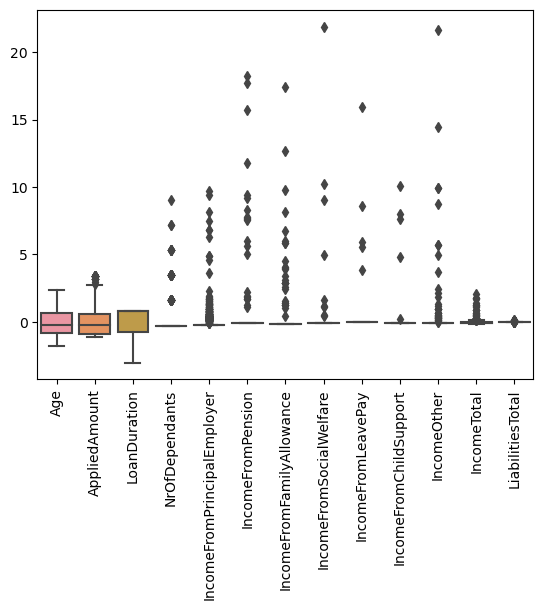

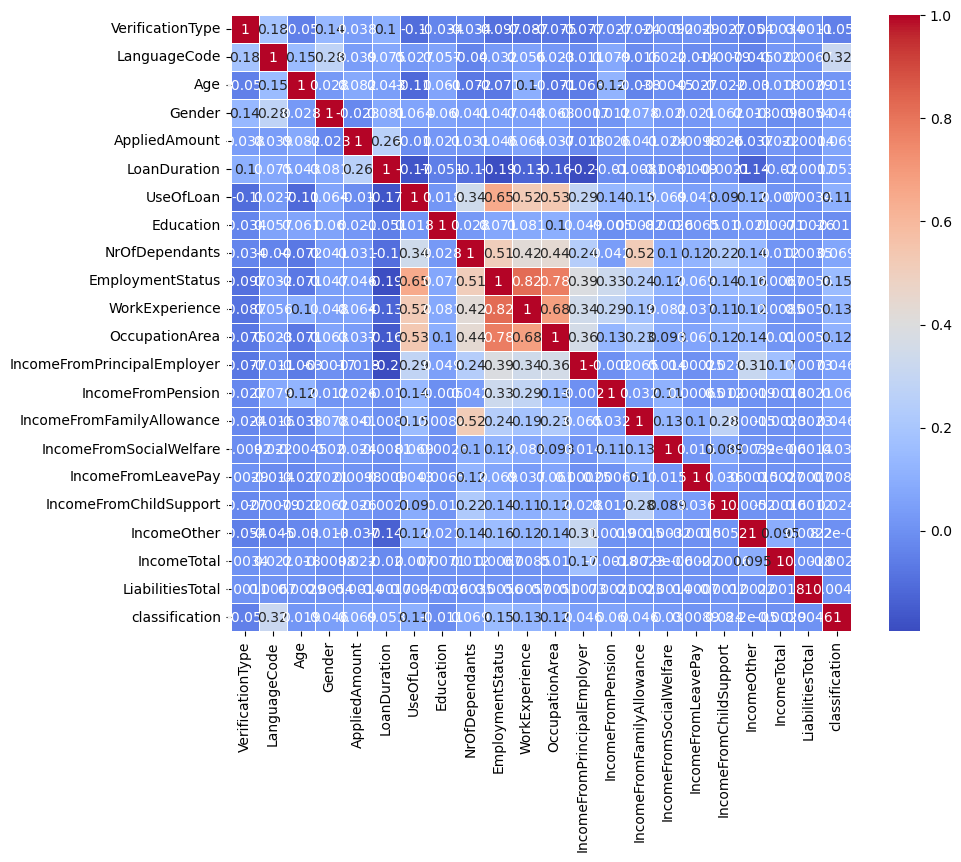

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path= "LoanData_Bondora_selected.csv"
data= pd.read_csv(path)


# 3.1.2 Data Inspection
# 1. Basic Summary Statistics
print(data.describe().T)

# 2. Check Data Dimensions and Data Types
data.info()

# 3. Identify Missing Values, Duplicates, and Outliers

data['DefaultDate'].replace(to_replace='.*', value=True, regex=True, inplace=True)
data['DefaultDate'].fillna(False, inplace = True)
data['DefaultDate']=data['DefaultDate'].astype(int)
data['VerificationType'].fillna(0, inplace = True)
data['VerificationType'] = data['VerificationType'].astype(int)
data['Gender'].fillna(2, inplace = True)
data['Gender'] = data['Gender'].astype(int)
data['AppliedAmount'] = data['AppliedAmount'].astype(int)

data['Education'].fillna(1, inplace = True)
data['Education'] = data['Education'].astype('category')
data['MaritalStatus'].fillna(3, inplace = True)
data['MaritalStatus'] = data['MaritalStatus'].astype('category')

data['EmploymentStatus'].fillna(1, inplace = True)
data['EmploymentStatus'] = data['EmploymentStatus'].astype('category')
data['OccupationArea'].fillna(1, inplace = True)
data['OccupationArea'] = data['OccupationArea'].astype(int)
data['HomeOwnershipType'].fillna(0, inplace = True)
data['HomeOwnershipType'] = data['HomeOwnershipType'].astype('category')
data['NrOfDependants'].fillna(0, inplace = True)
data['NrOfDependants'].replace(to_replace='10Plus', value=10, inplace=True)
data['NrOfDependants'] = data['NrOfDependants'].astype(int)

data['WorkExperience'].fillna(1, inplace = True)
data['WorkExperience'] = data['WorkExperience'].map({
    "MoreThan25Years": 35,
    "15To25Years": 25,
    "10To15Years": 15,
    "5To10Years": 10,
    "2To5Years": 5,
})
data['WorkExperience'].fillna(0, inplace = True)
data['WorkExperience'] = data['WorkExperience'].astype(int)
data['Education'] = data['Education'].astype(int)
data['EmploymentStatus'] = data['EmploymentStatus'].astype(int)
data.rename(columns={'DefaultDate': 'classification'}, inplace=True)
data.set_index('LoanNumber', inplace=True)
print( "\n Missing Values", data.isnull().sum())
print("\n Duplicates in the Data : ",data.duplicated().sum(),"\n ")

# 3.1.3 Data Cleaning
# 1. Impute Missing Values with Median
data_filled = data.fillna(data.median())

# 2. Remove Columns with Many Missing Values or Outliers
# Replace 'threshold' with the desired threshold for missing values or outliers
threshold = 0.2  # Example: 20% threshold
columns_to_remove = []
for column in data.columns:
    if (data[column].isnull().sum() / len(data)) > threshold:
        columns_to_remove.append(column)
data_cleaned = data.drop(columns=columns_to_remove)

# 3. Remove Duplicate Values
data_cleaned = data_cleaned.drop_duplicates()

# 3.1.4 Data Transformation
# 1. Categorical Variables to Numerical (Example: Label Encoding)
#numerical variables labels
numvars = ['Age','AppliedAmount', 'LoanDuration', 'NrOfDependants', 'IncomeFromPrincipalEmployer','IncomeFromPension','IncomeFromFamilyAllowance','IncomeFromSocialWelfare','IncomeFromLeavePay',
       'IncomeFromChildSupport', 'IncomeOther', 'IncomeTotal',
       'LiabilitiesTotal']
# Standardization
scaler = StandardScaler()
data[numvars] = scaler.fit_transform(data[numvars])

#categorical variables labels
catvars = ['VerificationType', 'LanguageCode', 'UseOfLoan', 'Education','WorkExperience',
           'MaritalStatus', 'EmploymentStatus', 'OccupationArea', 'HomeOwnershipType']

#One hot encoding, create dummy variables for every category of every categorical variable
dataset_1 = pd.get_dummies(data, columns=catvars, prefix=catvars).sample(n=1000,random_state=1)

# 3.1.5 Data Visualization
# 3. Box Plot for Numerical Data (After Cleaning)
boxplot_cleaned = sns.boxplot(data=dataset_2[numvars])
plt.xticks(rotation=90)
plt.show()

# 4. Correlation Heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


# Dataset2 - Gym fitness recommendation dataset<a id='Fitness'></a>


                    count     mean        std   min   25%   50%    75%    max
Age               10000.0  31.4655   7.546702  19.0  25.0  31.0   38.0   44.0
Weight            10000.0  62.9699  10.617489  45.0  54.0  63.0   72.0   81.0
HeartRate         10000.0  94.6426  14.730016  69.0  82.0  95.0  107.0  119.0
Duration_minutes  10000.0  82.1002  21.531798  45.0  64.0  82.0  100.0  119.0
AnklePain         10000.0   0.4969   0.500015   0.0   0.0   0.0    1.0    1.0
HipPain           10000.0   0.5117   0.499888   0.0   0.0   1.0    1.0    1.0
BackPain          10000.0   0.4944   0.499994   0.0   0.0   0.0    1.0    1.0
LegPain           10000.0   0.5068   0.499979   0.0   0.0   1.0    1.0    1.0
NeckPain          10000.0   0.5066   0.499981   0.0   0.0   1.0    1.0    1.0
Walking           10000.0   0.4979   0.500021   0.0   0.0   0.0    1.0    1.0
Weights           10000.0   0.4979   0.500021   0.0   0.0   0.0    1.0    1.0
Jogging           10000.0   0.5073   0.499972   0.0   0.0   1.0 

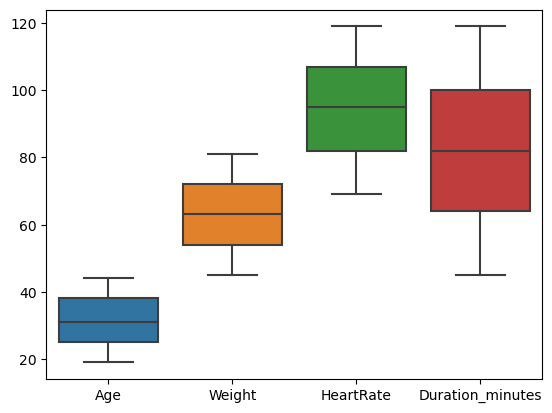

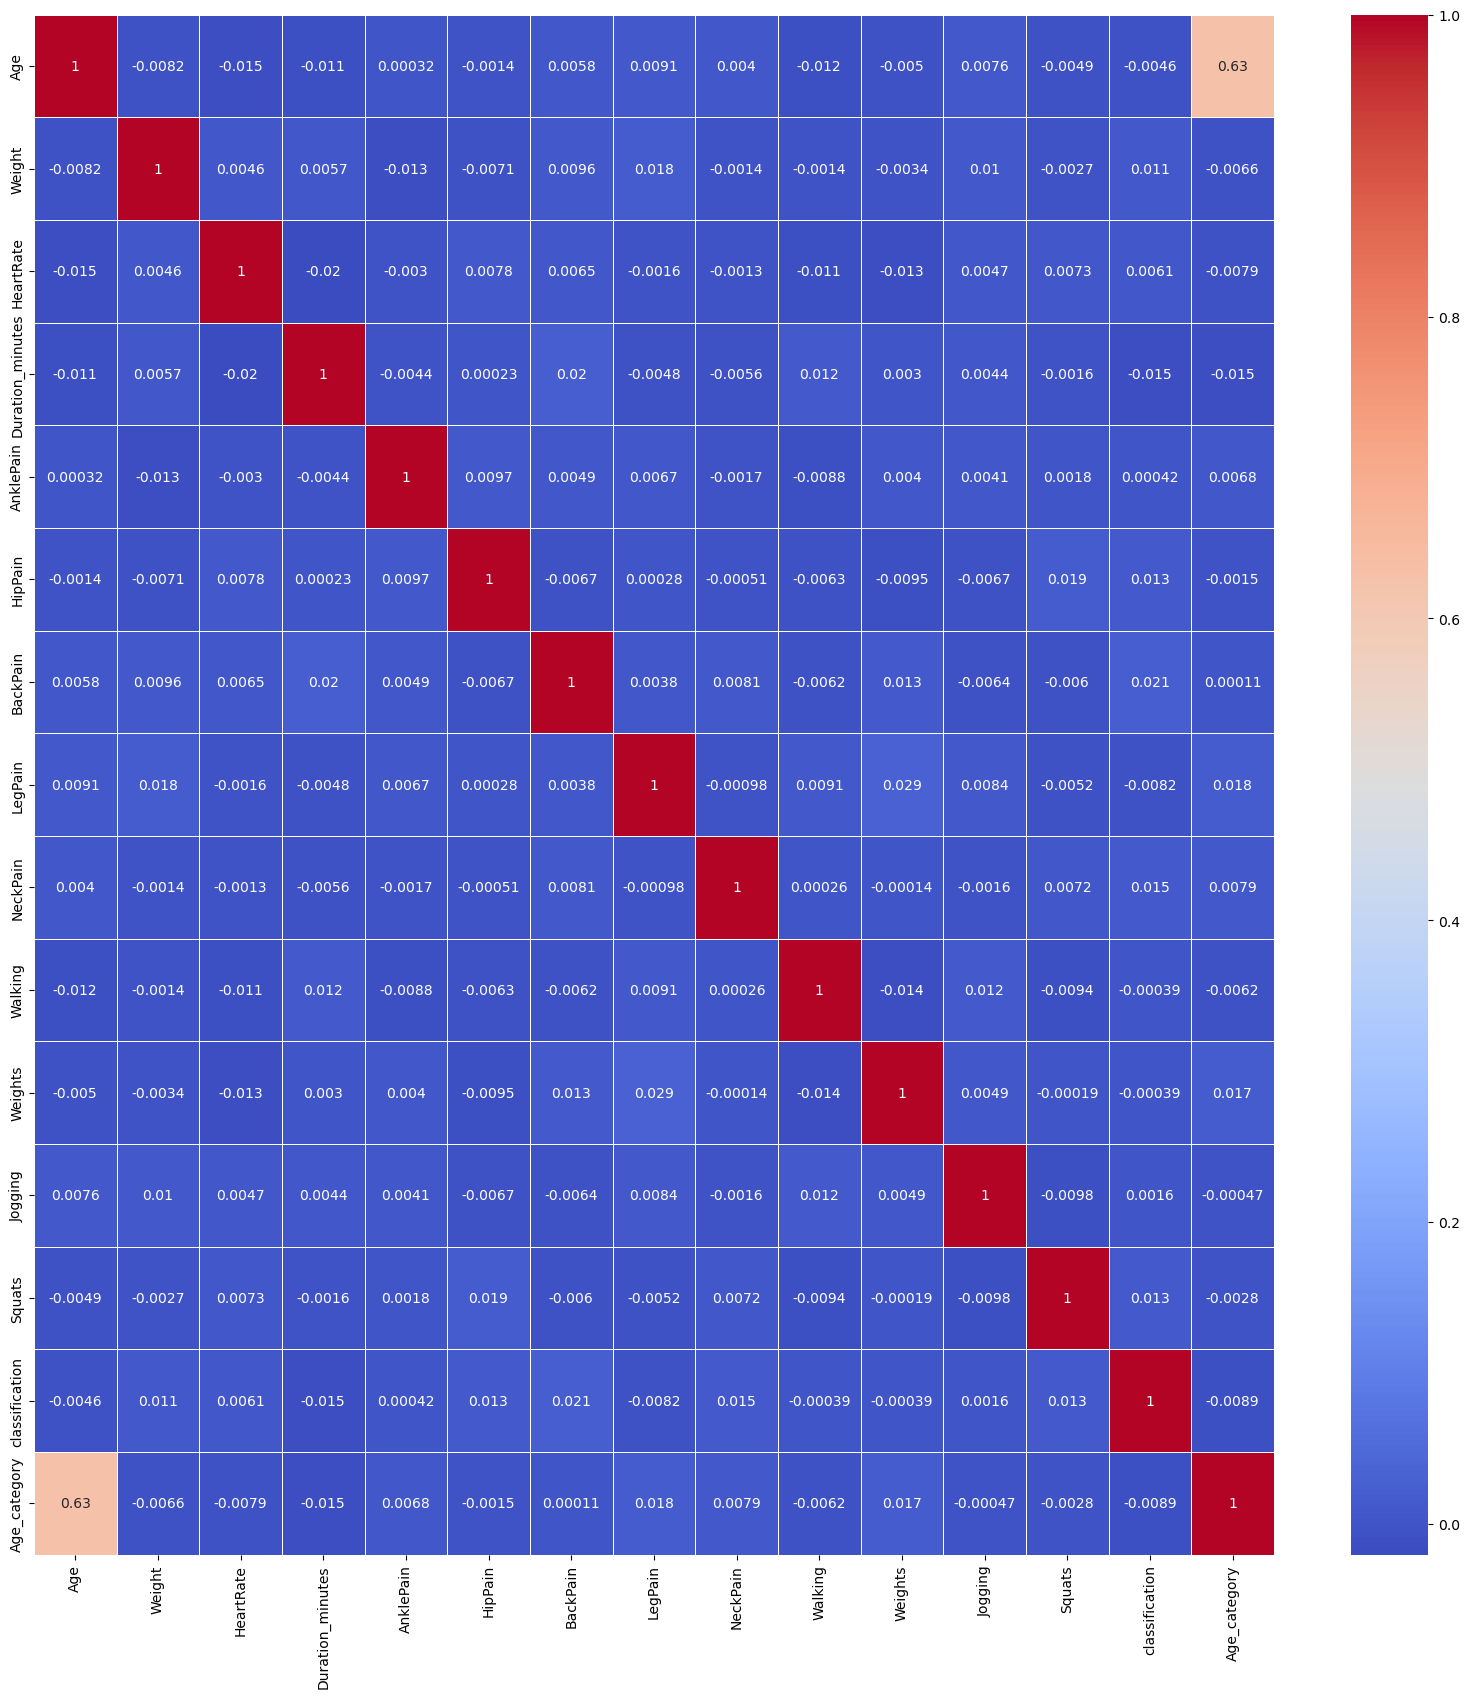

In [7]:
# The path to the CSV file was specified, and data was read from it.
path = "fitness.csv"
data = pd.read_csv(path)

# Descriptive statistics of the data were printed.
print(data.describe().T)

# Information about the data, including data types and missing values, was printed.
print(data.info())

# Missing values in the data were identified and printed.
print("\n Missing Values", data.isnull().sum())

# Duplicates in the data were identified and printed.
print("\n Duplicates in the Data: ", data.duplicated().sum(), "\n")

# Missing values in the data were filled with median values.
data_filled = data.fillna(data.median())

# A threshold for identifying columns to delete was set.
threshold = 0.2

# Columns with missing values exceeding the threshold were marked for deletion.
columns_for_deletion = []
for column in data.columns:
    if (data[column].isnull().sum() / len(data)) > threshold:
        columns_for_deletion.append(column)

# Columns marked for deletion were removed from the data.
data_cleaned = data.drop(columns=columns_for_deletion)

# Duplicate rows in the data were removed.
data_cleaned = data_cleaned.drop_duplicates()

# Numeric variables were selected for creating a boxplot.
numvars = ['Age', 'Weight', 'HeartRate', 'Duration_minutes']

# A boxplot of the selected numeric variables was created and displayed.
boxplot_cleaned = sns.boxplot(data=data[numvars])
plt.show()

# The 'Gym' column was renamed to 'classification'.
data.rename(columns={'Gym': 'classification'}, inplace=True)

# A new binary column 'Age_category' was created based on the 'Age' variable.
data['Age_category'] = (data['Age'] > 40).astype(int)

# Numeric variables were selected for standardization.
numvars = ['Age', 'Weight', 'HeartRate', 'Duration_minutes']

# Standard scaling was applied to the selected numeric variables.
scaler = StandardScaler()
data[numvars] = scaler.fit_transform(data[numvars])

# Categorical variables were specified.
catvars = ['AnklePain', 'HipPain', 'BackPain', 'LegPain', 'NeckPain', 'Gender']

# Dummy encoding was performed on the categorical variables.
dataset_2 = pd.get_dummies(data, columns=catvars, prefix=catvars).drop("Age_category", axis=1)
dataset_2_1 = pd.get_dummies(data, columns=catvars, prefix=catvars).drop("Age", axis=1)

# A correlation matrix of the data was calculated and visualized.
correlation_matrix = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


# Dataset3 - Auto insurance customers dataset<a id='insurance'></a>

                       count          mean           std           min  \
credit_score          9018.0      0.515813      0.137688      0.053358   
postal_code          10000.0  19864.548400  18915.613855  10238.000000   
annual_mileage        9043.0  11697.003207   2818.434528   2000.000000   
speeding_violations  10000.0      1.482900      2.241966      0.000000   
DUIs                 10000.0      0.239200      0.554990      0.000000   
past_accidents       10000.0      1.056300      1.652454      0.000000   
classification       10000.0      0.313300      0.463858      0.000000   

                              25%           50%           75%           max  
credit_score             0.417191      0.525033      0.618312      0.960819  
postal_code          10238.000000  10238.000000  32765.000000  92101.000000  
annual_mileage       10000.000000  12000.000000  14000.000000  22000.000000  
speeding_violations      0.000000      0.000000      2.000000     22.000000  
DUIs             

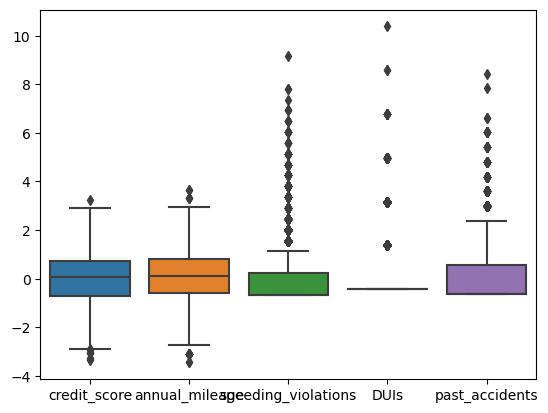

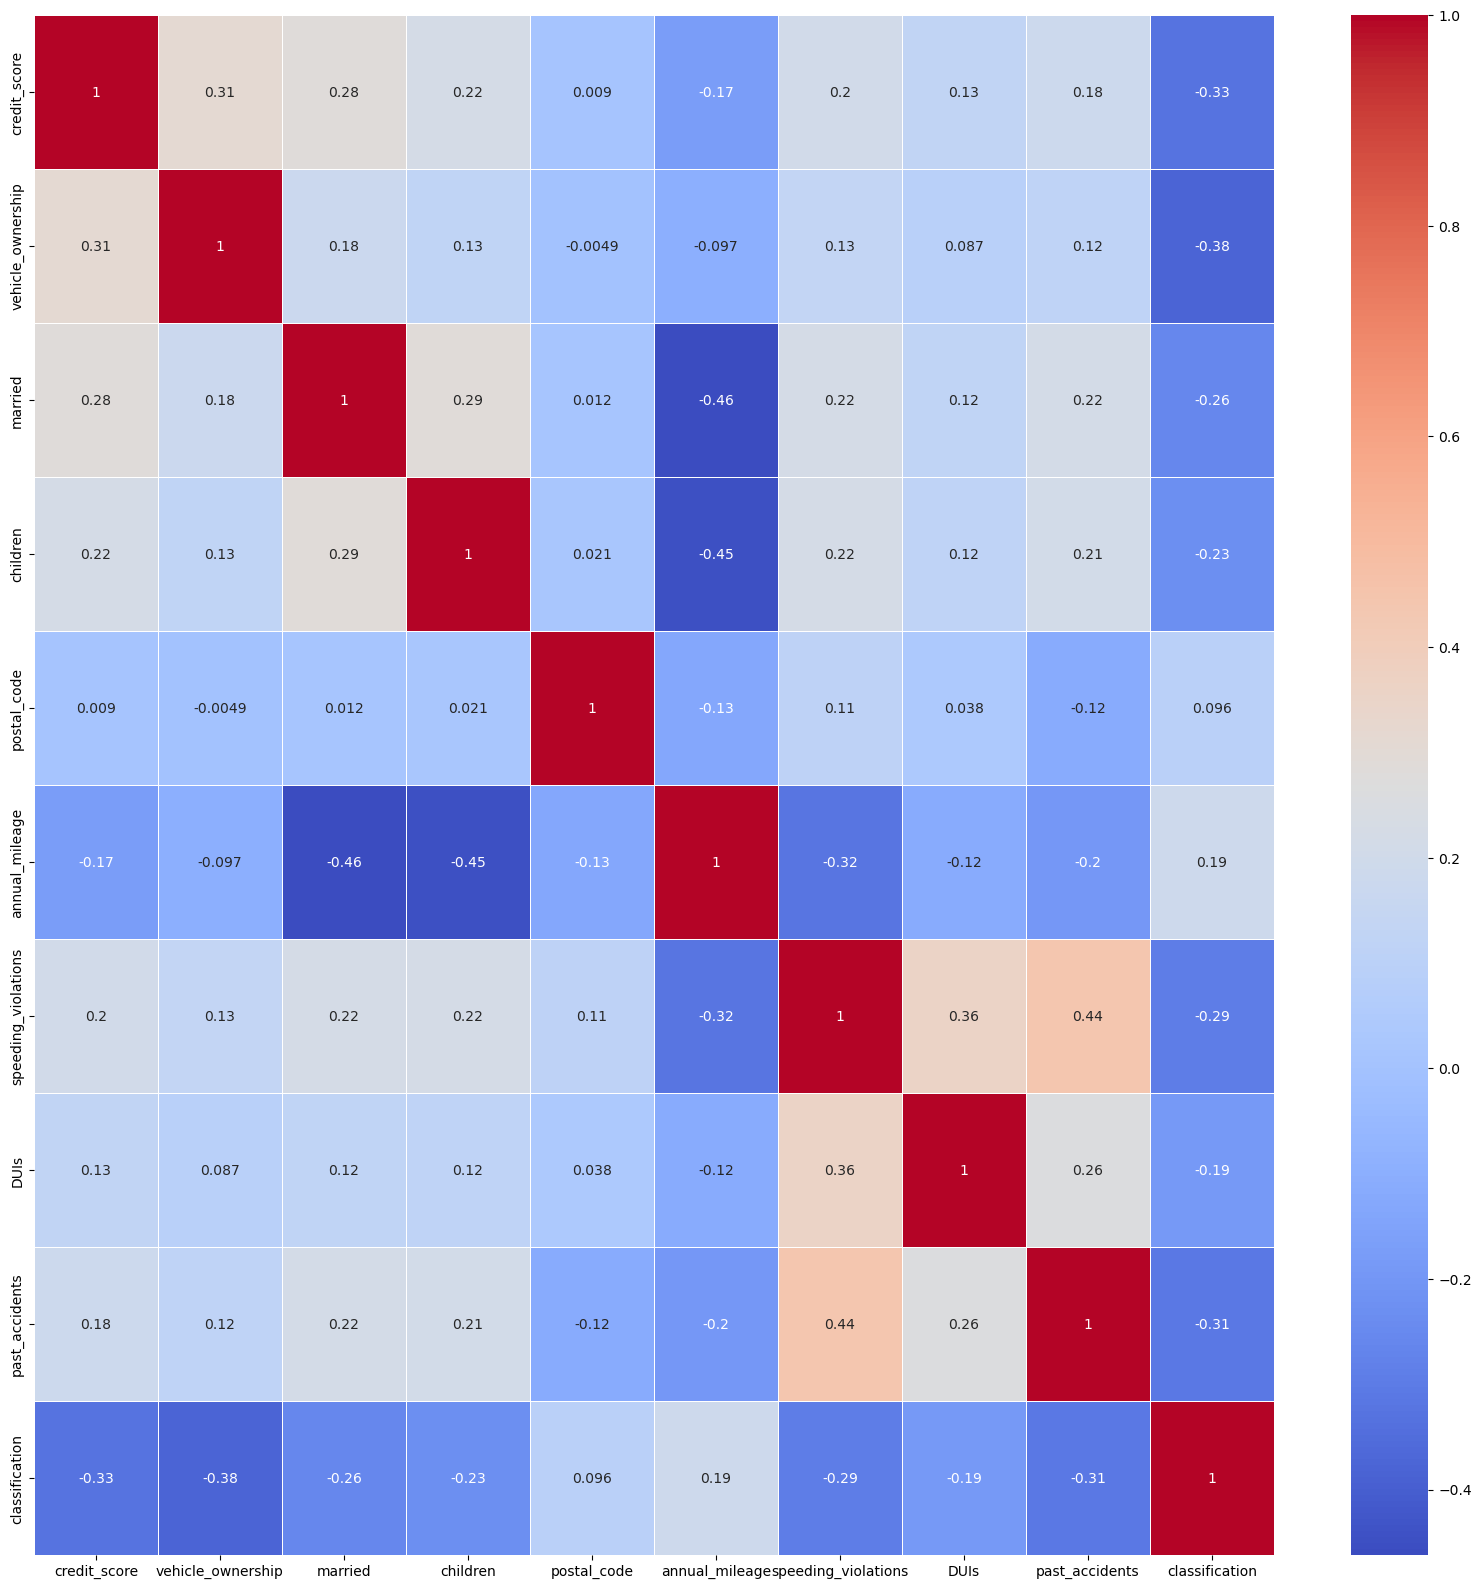

In [8]:
path= "customer-data.csv"
data= pd.read_csv(path)

data.set_index('id', inplace=True)
data.rename(columns={'outcome': 'classification'}, inplace=True)
data["classification"]=data["classification"].astype(int)
numvars = ['credit_score','annual_mileage', 'speeding_violations', 'DUIs','past_accidents']

# 3.1.2 Data Inspection
# 1. Basic Summary Statistics
print(data.describe().T)

# 2. Check Data Dimensions and Data Types
print(data.info())

# 3. Identify Missing Values, Duplicates, and Outliers
print( "\n Missing Values", data.isnull().sum())
print("\n Duplicates in the Data : ",data.duplicated().sum(),"\n ")


# 3.1.3 Data Cleaning
# 1. Impute Missing Values with Median
data_filled = data.fillna(data.median())

# 2. Remove Columns with Many Missing Values or Outliers
# Replace 'threshold' with the desired threshold for missing values or outliers
threshold = 0.2  # Example: 20% threshold
columns_to_remove = []
for column in data.columns:
    if (data[column].isnull().sum() / len(data)) > threshold:
        columns_to_remove.append(column)
data_cleaned = data.drop(columns=columns_to_remove)

# 3. Remove Duplicate Values
data_cleaned = data_cleaned.drop_duplicates()


# 3.1.4 Data Transformation

scaler = StandardScaler()
data[numvars] = scaler.fit_transform(data[numvars])

catvars = ['age','gender','race','driving_experience','education','income','vehicle_ownership','vehicle_year','married','children','postal_code','vehicle_type']

#One hot encoding, create dummy variables for every category of every categorical variable
dataset_3 = pd.get_dummies(data, columns=catvars, prefix=catvars).dropna()
# 3.1.5 Data Visualization
# 3. Box Plot for Numerical Data (After Cleaning)
boxplot_cleaned = sns.boxplot(data=data[numvars])
plt.show()

# 4. Correlation Heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# Runs and Results<a id='Results'></a>

[Back to Classification programs used](#Classification)<br><br>

In [ ]:
dataset_names=[dataset_1,dataset_2,dataset_2_1,dataset_3]
protected_atrributes=["Gender","Gender_Female","Age_category","gender_female"]
run_names=["Bondora","Fitness Data Gender","Fitness Data Age","Insurance Data Gender"]
for i in range(4):
    for j in range(6):
        data_sample=dataset_names[i].sample(n=500, replace=True)
        models = Fair_Classification(data_sample,protected_atrributes[i],run_names[i]) 
        models.display("Result 1409_0_1_without_db.xlsx")
        print(run_names[i]+"  - round  "+str(j)+" complete")

# Statistical Tests <a id='Stats'></a>

### Wilcoxon Test to check if Random Forest is better than other models

#### Demographic parity

In [159]:
path= "Final/Summary Demographic parity.csv"
summary= pd.read_csv(path)

result=pd.DataFrame(columns=["Test Name","Model","p-value","comment"])
count=1
for i in range(2,5):
    k=summary.columns[i]
    fairness_random_forest = summary["Random Forest"].astype(float)
    fairness_other_model = summary[k].astype(float)
    
    sig = 0.05
    
    # Calculate the differences in fairness metrics (Random Forest - Model B)
    fairness_differences = fairness_random_forest - fairness_other_model

    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(fairness_differences, alternative='less')
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test left tail only"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant negative difference in fairness (Random Forest <"+ k+").\n"
    else:
        result.at[count,"comment"]="There is no significant negative difference in fairness (Random Forest >= "+ k+").\n"
    
    count=count+1
    
    statistic, p_value = wilcoxon(fairness_differences)
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test both tail"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant difference in fairness (Random Forest <"+ k+").\n"
    else:
        result.at[count,"comment"]="There is no significant difference in fairness (Random Forest >= "+ k+").\n"

    count=count+1
    
    statistic, p_value = stats.ttest_rel(fairness_random_forest, fairness_other_model)

 
result

,Test Name,Model,p-value,comment
1,Wilcoxon Rank-Sum Test left tail only,K-nearest neighbours,0.054022,There is no significant negative difference in fairness (Random Forest >= K-nearest neighbours).\n
2,Wilcoxon Rank-Sum Test both tail,K-nearest neighbours,0.108043,There is no significant difference in fairness (Random Forest >= K-nearest neighbours).\n
3,Wilcoxon Rank-Sum Test left tail only,Logistic Regression,0.008935,There is a significant negative difference in fairness (Random Forest <Logistic Regression).\n
4,Wilcoxon Rank-Sum Test both tail,Logistic Regression,0.01787,There is a significant difference in fairness (Random Forest <Logistic Regression).\n
5,Wilcoxon Rank-Sum Test left tail only,Neural Network,0.0,There is a significant negative difference in fairness (Random Forest <Neural Network).\n
6,Wilcoxon Rank-Sum Test both tail,Neural Network,0.0,There is a significant difference in fairness (Random Forest <Neural Network).\n


#### Predictive Parity Rate

In [160]:

path= "Final/Summary TPR parity.csv"
summary= pd.read_csv(path)

result=pd.DataFrame(columns=["Test Name","Model","p-value","comment"])
count=1
for i in range(2,5):
    k=summary.columns[i]
    fairness_random_forest = summary["Random Forest"].astype(float)
    fairness_other_model = summary[k].astype(float)
    
    sig = 0.05
    
    # Calculate the differences in fairness metrics (Random Forest - Model B)
    fairness_differences = fairness_random_forest - fairness_other_model

    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(fairness_differences, alternative='less')
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test left tail only"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant negative difference in fairness (Random Forest <"+ k+").\n"
    else:
        result.at[count,"comment"]="There is no significant negative difference in fairness (Random Forest >= "+ k+").\n"
    
    count=count+1
    
    statistic, p_value = wilcoxon(fairness_differences)
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test both tail"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant difference in fairness (Random Forest <"+ k+").\n"
    else:
        result.at[count,"comment"]="There is no significant difference in fairness (Random Forest >= "+ k+").\n"

    count=count+1
    
    statistic, p_value = stats.ttest_rel(fairness_random_forest, fairness_other_model)

 
result

,Test Name,Model,p-value,comment
1,Wilcoxon Rank-Sum Test left tail only,K-nearest neighbours,0.331973,There is no significant negative difference in fairness (Random Forest >= K-nearest neighbours).\n
2,Wilcoxon Rank-Sum Test both tail,K-nearest neighbours,0.663947,There is no significant difference in fairness (Random Forest >= K-nearest neighbours).\n
3,Wilcoxon Rank-Sum Test left tail only,Logistic Regression,0.015426,There is a significant negative difference in fairness (Random Forest <Logistic Regression).\n
4,Wilcoxon Rank-Sum Test both tail,Logistic Regression,0.030853,There is a significant difference in fairness (Random Forest <Logistic Regression).\n
5,Wilcoxon Rank-Sum Test left tail only,Neural Network,0.0,There is a significant negative difference in fairness (Random Forest <Neural Network).\n
6,Wilcoxon Rank-Sum Test both tail,Neural Network,0.0,There is a significant difference in fairness (Random Forest <Neural Network).\n


#### Equalised odds

In [161]:
from scipy.stats import wilcoxon
path= "Final/Summary Equalised odds.csv"
summary= pd.read_csv(path)
count=1
for i in range(2,5):
    k=summary.columns[i]
    fairness_random_forest = summary["Random Forest"].astype(float)
    fairness_other_model = summary[k].astype(float)
    
    sig = 0.05
    
    # Calculate the differences in fairness metrics (Random Forest - Model B)
    fairness_differences = fairness_random_forest - fairness_other_model
    
    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(fairness_differences, alternative='less')
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test left tail only"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant negative difference in fairness (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant negative difference in fairness (Random Forest >= "+ k+")."
    
    count=count+1
    
    statistic, p_value = wilcoxon(fairness_differences)
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test both tail"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant difference in fairness (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant difference in fairness (Random Forest >= "+ k+")."

    count=count+1
    
    statistic, p_value = stats.ttest_rel(fairness_random_forest, fairness_model_B)

    # Set the significance level (sig)

    result.at[count,"Test Name"]="T-Test "
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value
  
    if p_value < sig:
        result.at[count,"comment"]="There is a significant negative difference in fairness (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant negative difference in fairness (Random Forest >= "+ k+")."
    
    count=count+1 
result

,Test Name,Model,p-value,comment
1,Wilcoxon Rank-Sum Test left tail only,K-nearest neighbours,0.284967,There is no significant negative difference in fairness (Random Forest >= K-nearest neighbours).
2,Wilcoxon Rank-Sum Test both tail,K-nearest neighbours,0.569934,There is no significant difference in fairness (Random Forest >= K-nearest neighbours).
3,T-Test,K-nearest neighbours,0.000014,There is a significant negative difference in fairness (Random Forest <K-nearest neighbours).
4,Wilcoxon Rank-Sum Test left tail only,Logistic Regression,0.024531,There is a significant negative difference in fairness (Random Forest <Logistic Regression).
5,Wilcoxon Rank-Sum Test both tail,Logistic Regression,0.049061,There is a significant difference in fairness (Random Forest <Logistic Regression).
6,T-Test,Logistic Regression,0.000014,There is a significant negative difference in fairness (Random Forest <Logistic Regression).
7,Wilcoxon Rank-Sum Test left tail only,Naive Bayes,0.050253,There is no significant negative difference in fairness (Random Forest >= Naive Bayes).
8,Wilcoxon Rank-Sum Test both tail,Naive Bayes,0.100506,There is no significant difference in fairness (Random Forest >= Naive Bayes).
9,T-Test,Naive Bayes,0.000014,There is a significant negative difference in fairness (Random Forest <Naive Bayes).


#### Mutual Information

In [171]:
from scipy.stats import wilcoxon
path= "Final/Summary Mi.csv"
summary= pd.read_csv(path)
count=1
for i in range(2,5):
    k=summary.columns[i]
    fairness_random_forest = summary["Random_Forest"].astype(float)
    fairness_other_model= summary[k].astype(float)
    
    sig = 0.05
    
    # Calculate the differences in fairness metrics (Random Forest - Model B)
    fairness_differences = fairness_random_forest - fairness_other_model
    
    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(fairness_differences, alternative='less')
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test left tail only"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant negative difference in fairness (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant negative difference in fairness (Random Forest >= "+ k+")."
    
    count=count+1
    
    statistic, p_value = wilcoxon(fairness_differences)
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test both tail"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant difference in fairness (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant difference in fairness (Random Forest >= "+ k+")."

    count=count+1
    
    statistic, p_value = stats.ttest_rel(fairness_random_forest, fairness_other_model)

    # Set the significance level (sig)

    result.at[count,"Test Name"]="T-Test "
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value
  
    if p_value < sig:
        result.at[count,"comment"]="There is a significant negative difference in fairness (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant negative difference in fairness (Random Forest >= "+ k+")."
    
    count=count+1 
result

,Test Name,Model,p-value,comment
1,Wilcoxon Rank-Sum Test left tail only,K-nearest neighbours,0.416687,There is no significant negative difference in fairness (Random Forest >= K-nearest neighbours).
2,Wilcoxon Rank-Sum Test both tail,K-nearest neighbours,0.833373,There is no significant difference in fairness (Random Forest >= K-nearest neighbours).
3,T-Test,K-nearest neighbours,0.10438,There is no significant negative difference in fairness (Random Forest >= K-nearest neighbours).
4,Wilcoxon Rank-Sum Test left tail only,Logistic Regression,0.013058,There is a significant negative difference in fairness (Random Forest < Logistic Regression ).
5,Wilcoxon Rank-Sum Test both tail,Logistic Regression,0.026116,There is a significant difference in fairness (Random Forest < Logistic Regression ).
6,T-Test,Logistic Regression,0.521455,There is no significant negative difference in fairness (Random Forest >= Logistic Regression ).
7,Wilcoxon Rank-Sum Test left tail only,Neural Network,0.006302,There is a significant negative difference in fairness (Random Forest <Neural Network).
8,Wilcoxon Rank-Sum Test both tail,Neural Network,0.012605,There is a significant difference in fairness (Random Forest <Neural Network).
9,T-Test,Neural Network,0.132451,There is no significant negative difference in fairness (Random Forest >= Neural Network).


#### Accuracy

In [157]:
from scipy.stats import wilcoxon
path= "Final/Summary accuracy.csv"
summary= pd.read_csv(path)
count=1
result=pd.DataFrame(columns=["Test Name","Model","p-value","comment"])
for i in range(2,5):
    k=summary.columns[i]
    fairness_random_forest = summary["Random Forest"].astype(float)
    fairness_other_model = summary[k].astype(float)
    
    sig = 0.05
    
    # Calculate the differences in fairness metrics (Random Forest - the other model)
    fairness_differences = fairness_random_forest - fairness_other_model

    # Perform the Wilcoxon signed-rank test
    statistic, p_value = wilcoxon(fairness_differences, alternative='less')
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test left tail only"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant negative difference in accuracy (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant negative difference in accuracy (Random Forest >= "+ k+")."
    
    count=count+1
    
    statistic, p_value = wilcoxon(fairness_differences)
    
    result.at[count,"Test Name"]="Wilcoxon Rank-Sum Test both tail"
    result.at[count,"Model"]=k
    result.at[count,"p-value"]=p_value

    if p_value < sig:
        result.at[count,"comment"]="There is a significant difference in accuracy (Random Forest <"+ k+")."
    else:
        result.at[count,"comment"]="There is no significant difference in accuracy (Random Forest >= "+ k+")."

    count=count+1
    
    statistic, p_value = stats.ttest_rel(fairness_random_forest, fairness_other_model)

result

,Test Name,Model,p-value,comment
1,Wilcoxon Rank-Sum Test left tail only,K-nearest neighbours,0.411056,There is no significant negative difference in accuracy (Random Forest >= K-nearest neighbours).
2,Wilcoxon Rank-Sum Test both tail,K-nearest neighbours,0.822112,There is no significant difference in accuracy (Random Forest >= K-nearest neighbours).
3,Wilcoxon Rank-Sum Test left tail only,Logistic Regression,0.017834,There is a significant negative difference in accuracy (Random Forest <Logistic Regression).
4,Wilcoxon Rank-Sum Test both tail,Logistic Regression,0.035668,There is a significant difference in accuracy (Random Forest <Logistic Regression).
5,Wilcoxon Rank-Sum Test left tail only,Neural Network,0.016372,There is a significant negative difference in accuracy (Random Forest <Neural Network ).
6,Wilcoxon Rank-Sum Test both tail,Neural Network,0.032743,There is a significant difference in accuracy (Random Forest <Neural Network ).


#### Impact of changing hyperparameters

In [11]:
# The required library was imported.

path= "Final/ANOVA.csv"
summary= pd.read_csv(path)

# Variances in each type of fairness metrics and accuracy are tested.
variance_data = summary.iloc[:, 2:7]
varlist = ["Variance in demogarphic parity", "Variance Equalized Odds TPR/Predictive Parity %", "Variance Equalized Odds FPR %"]

# Iterated through the variance is each of the fairness metrics and accuracy
for var in varlist:
    print("\n", var, "\n")
    # Performed Levene's test to compare variances.
    statistic, p_value = stats.levene(variance_data["Variance in accuracy"], variance_data[var])

    # Checked the p-value to determine significance.
    sig = 0.05  # Set the significance level.
    if p_value < sig:
        print("The null hypothesis was rejected: Variances are not equal between Accuracy and " + var + "\n with a p-value of " + str(p_value))
    else:
        print("The null hypothesis was not rejected: Variances are equal." + "\n with a p-value of " + str(p_value))




 Variance in demogarphic parity 

The null hypothesis was rejected: Variances are not equal between Accuracy and Variance in demogarphic parity
 with a p-value of 1.9703844428789636e-05

 Variance Equalized Odds TPR/Predictive Parity % 

The null hypothesis was rejected: Variances are not equal between Accuracy and Variance Equalized Odds TPR/Predictive Parity %
 with a p-value of 4.062111908681615e-09

 Variance Equalized Odds FPR % 

The null hypothesis was rejected: Variances are not equal between Accuracy and Variance Equalized Odds FPR %
 with a p-value of 1.0976973950524401e-08


#### Impact of changing the decision boundary

In [158]:

# The data was loaded from CSV files
path1 = "Final/All_results_1409_0_1_with_db.csv"
summary1 = pd.read_csv(path1)

path2 = "Final/All_results_1409_0_1_without_db.csv"
summary2 = pd.read_csv(path2)

# A DataFrame was created to store the test results
result = pd.DataFrame(columns=["Test Name", "Model", "p-value", "comment"])
count = 1

# An option for displaying long text columns was configured
pd.set_option('display.max_colwidth', None)

# Iterating through columns containing fairness metrics
for i in range(2, 6):
    k = summary1.columns[i]
    fairness_with_db = summary1.T.iloc[i]
    fairness_without_db = summary2.T.iloc[i]
    sig = 0.05

    # Calculated the differences in fairness metrics (Random Forest - fairness_other_model)
    fairness_differences = fairness_with_db - fairness_without_db

    # Conducted the Wilcoxon signed-rank test (left tail only)
    statistic, p_value = wilcoxon(fairness_differences, alternative='less')

    # Stored test results and comments
    result.at[count, "Test Name"] = "Wilcoxon Rank-Sum Test left tail only"
    result.at[count, "Model"] = k
    result.at[count, "p-value"] = p_value

    if p_value < sig:
        result.at[count, "comment"] = "A significant negative difference in fairness was found"
    else:
        result.at[count, "comment"] = "No significant negative difference in fairness was found"

    count += 1

    # Conducted the Wilcoxon signed-rank test (both tails)
    statistic, p_value = wilcoxon(fairness_differences)

    # Stored test results and comments
    result.at[count, "Test Name"] = "Wilcoxon Rank-Sum Test both tail"
    result.at[count, "Model"] = k
    result.at[count, "p-value"] = p_value

    if p_value < sig:
        result.at[count, "comment"] = "A significant difference in fairness was detected"
    else:
        result.at[count, "comment"] = "No significant difference in fairness was detected"

    count += 1

    # Performed a t-test (please specify fairness_random_forest and fairness_other_model)
    statistic, p_value = stats.ttest_rel(fairness_random_forest, fairness_other_model)

# The resulting DataFrame containing the test results is returned
result


,Test Name,Model,p-value,comment
1,Wilcoxon Rank-Sum Test left tail only,Accuracy,0.00002,There is a significant negative difference in fairness
2,Wilcoxon Rank-Sum Test both tail,Accuracy,0.00004,There is a significant difference \n in fairness
3,Wilcoxon Rank-Sum Test left tail only,Demographic Parity %,0.000045,There is a significant negative difference in fairness
4,Wilcoxon Rank-Sum Test both tail,Demographic Parity %,0.00009,There is a significant difference \n in fairness
5,Wilcoxon Rank-Sum Test left tail only,Equalized Odds TPR/Predictive Parity %,0.002074,There is a significant negative difference in fairness
6,Wilcoxon Rank-Sum Test both tail,Equalized Odds TPR/Predictive Parity %,0.004149,There is a significant difference \n in fairness
7,Wilcoxon Rank-Sum Test left tail only,Equalized Odds FPR %,0.00062,There is a significant negative difference in fairness
8,Wilcoxon Rank-Sum Test both tail,Equalized Odds FPR %,0.001241,There is a significant difference \n in fairness
